In [1]:
from datasets import *
from debugging import *
from analytics import *
from augmentations import *

In [20]:
import numpy as np

np.array([[]], dtype=np.float32).shape

(1, 0)

In [24]:
def shape_coin_output(d_img, d_bb, img, box, cls=0):
    """
    matches output signature
    :param d_img: bool
    :param d_bb: bool
    :param img: np.array
    :param box: np.array
    :param cls: int
    :return:
    """

    import numpy as np

    boxes = np.array(box, dtype=np.float32)
    classes = np.array([], dtype=np.int32) if boxes.shape[-1] == 0 else np.array([cls], dtype=np.int32)
    # if boxes classes is empty then we just return an empty array for classes

    x = {"images": img} if d_img else img
    y = {
        "bounding_boxes": {
            "boxes": boxes,
            "classes": classes
        }
    } if d_bb else {
        "boxes": boxes,
        "classes": classes
    }

    return x, y


def multi_coin_ds(xml_paths, nobox=True, togray=False, visibility=None, format='xywh', tsz=(1024, 1024), d_img=True,
                  d_bb=True, shuffle=True, use32=True):
    """

    :param xml_paths: (xml_path, ext) = ext may be none
    :param togray: only when images have transparency. makes the background gray
    :param visibility: filter by visibility
    :param format: any supported by keras_cv.bounding_box.convert_format
    :param tsz: target size for resize (h, w)
    :param d_img:
    :param d_bb:
    :param shuffle: set to shuffle training data
    :param use32: image precision after normalisation: true=32, false=16.
    :return: Generator of image (normalised) and labels.
    """
    from pathlib import Path
    import xml.etree.ElementTree as ET
    import random
    from PIL import Image
    import numpy as np
    import keras_cv
    import tensorflow as tf

    samples = []
    for xml_path, ext in xml_paths:

        image_folder = Path(xml_path).parent / "images"
        tree = ET.parse(xml_path)
        root = tree.getroot()
        for image in root.findall('image'):

            fn = image.get('name') + (('.' + ext) if ext is not None else '')
            full = image_folder / fn

            if not full.exists():
                raise FileNotFoundError(str(full))

            box = image.find('box')

            if box is None:
                if nobox:
                    continue
                else:
                    samples.append((
                        str(full),
                        int(image.get('width')),
                        int(image.get('height')),
                        None,
                    ))

            attr = box.find('attribute')

            vis = attr.text if attr is not None and attr.get('name') == 'visibility' else None
            if visibility is not None and vis not in visibility:
                continue

            samples.append((
                str(full),
                int(image.get('width')),  # Image's height
                int(image.get('height')),  # Image's width
                # Also known as xyxy or xmin, ymin, xmax, ymax
                (
                    float(box.get('xtl')),  # Top left X
                    float(box.get('ytl')),  # Top left Y
                    float(box.get('xbr')),  # Bottom right X
                    float(box.get('ybr'))  # Bottom right Y
                )
            ))

    if shuffle:
        random.shuffle(samples)

    def generator():
        for path, width, height, xyxy in samples:
            img = Image.open(path)

            if togray and img.mode == 'RGBA':
                bg = Image.new("RGB", img.size, (128, 128, 128))
                bg.paste(img, (0, 0), img)
                finalimg = bg
            else:
                finalimg = img.convert('RGB')

            finalimg = finalimg.resize(tsz)
            finalimg = (np.array(finalimg) / 255.0).astype(np.float32 if use32 else np.float16)

            img.close()

            if xyxy is not None:
                xtl, ytl, xbr, ybr = xyxy
                box = np.array(keras_cv.bounding_box.convert_format(
                    np.array([
                        [  # Transforms origin xyxy to resized xyxy
                            xtl * tsz[0] / width,
                            ytl * tsz[1] / height,
                            xbr * tsz[0] / width,
                            ybr * tsz[1] / height]
                    ], dtype=np.float32),
                    'xyxy', format, image_shape=(*tsz, 3)  # Then back to whatever the user wants.
                ),
                    dtype=np.float32)
            else:
                box = np.array([], dtype=np.float32)

            yield shape_coin_output(d_img, d_bb, finalimg, box)

    ds = tf.data.Dataset.from_generator(generator, output_signature=build_output_signature(d_img, d_bb, tsz, use32))
    ds = ds.apply(tf.data.experimental.assert_cardinality(len(samples)))

    return ds

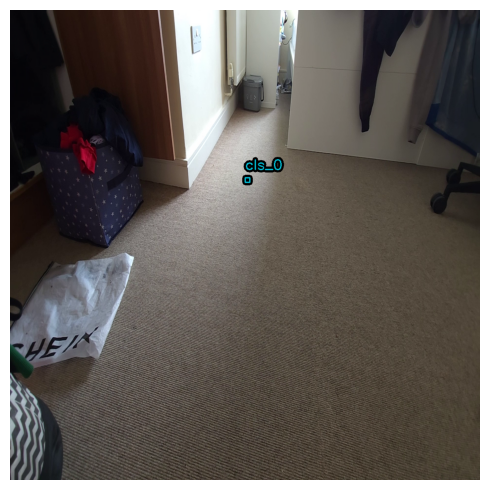

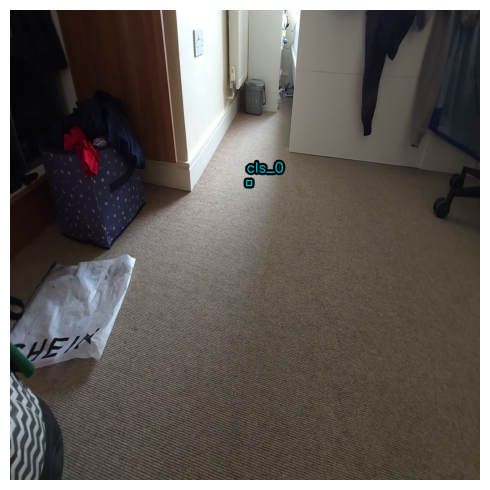

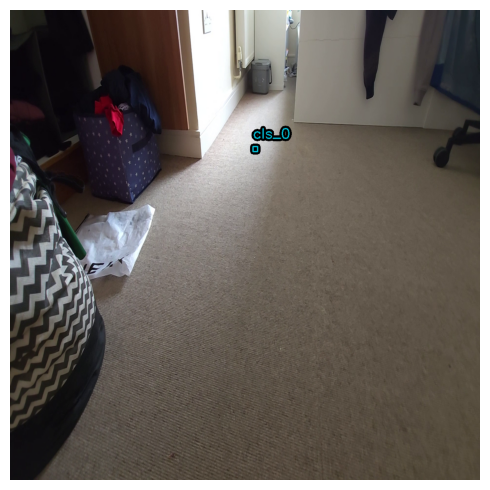

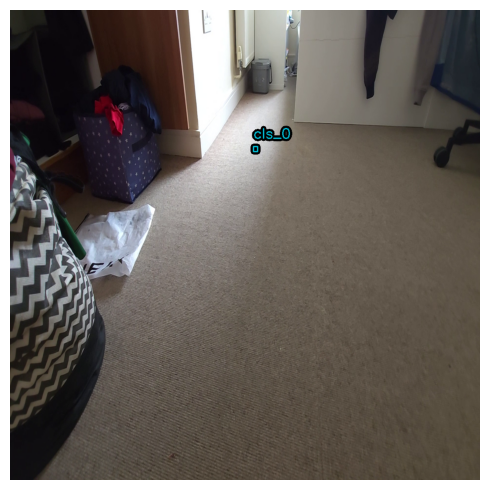

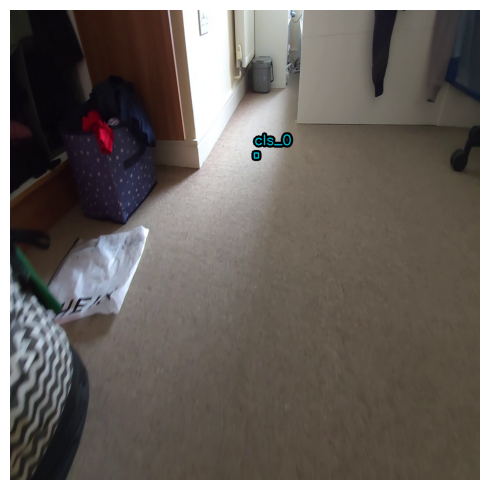

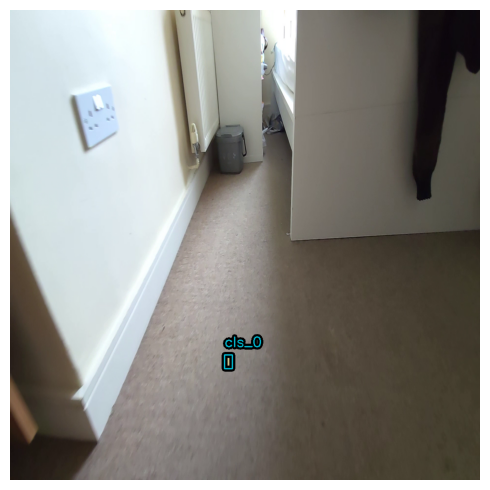

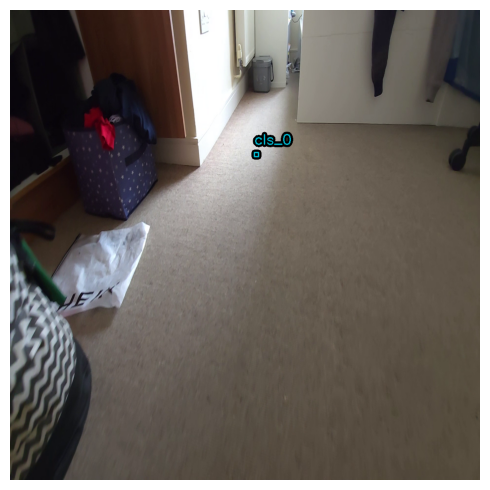

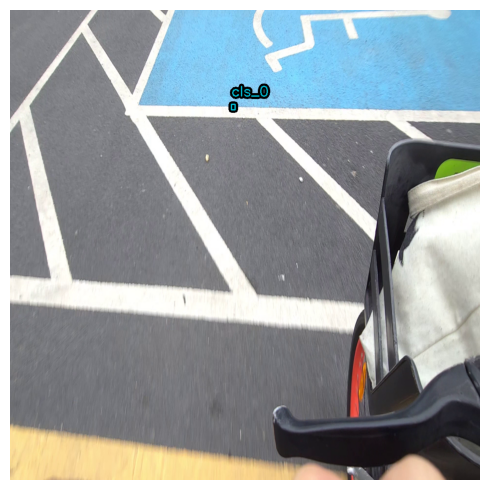

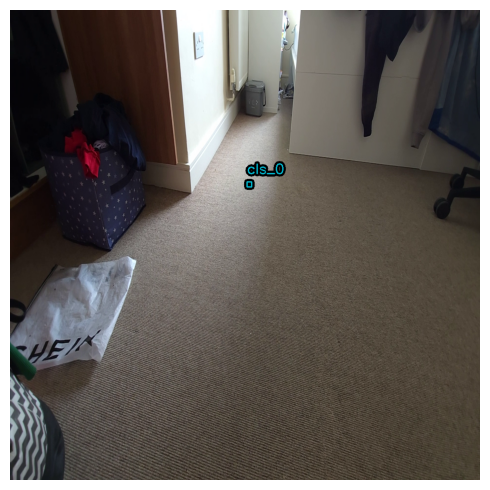

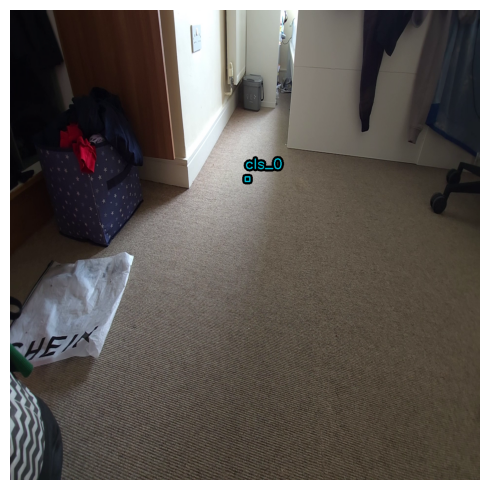

In [34]:
visualise_sample(video_clear.take(10))